<a href="https://colab.research.google.com/github/der-himmel/obr-iz/blob/main/recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [506]:
! pip install albumentations opencv-python

In [507]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
import albumentations as A

In [508]:
def preprocess_image(image_path):
    # Загрузка изображения
    image = io.imread(image_path)
    height, width = image.shape[:2]

    padding = max(width, height) // 2
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    transform = A.Compose([
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.3),
      A.Rotate(limit=(0, 90), p=1.0),
      A.RandomBrightnessContrast(p=0.2),
      # A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
      # A.Blur(blur_limit=3, p=0.1),
    ])

    image = transform(image=padded_image)['image']

    return image

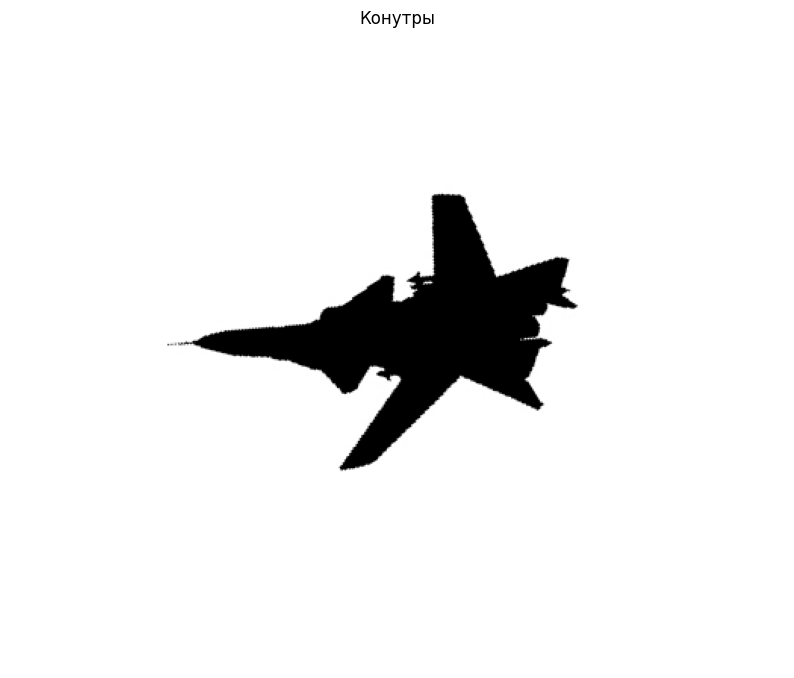

In [509]:
PATH = 'test-img/2-256.jpg'
# PATH = 'test-img/cg-test2.jpg'

image = preprocess_image(PATH)

all_characteristic_points = []

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
plt.show()

In [510]:
# output_image = np.zeros_like(binary_image)

# cv2.circle(output_image, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)
# cv2.drawContours(output_image, contours[::-1], -1, (255), thickness=1)

# plt.figure(figsize=(10, 10))
# plt.imshow(output_image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
# plt.show()

In [511]:
def binarize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

    return binary_image

CG = [265.67567568 203.34414414]


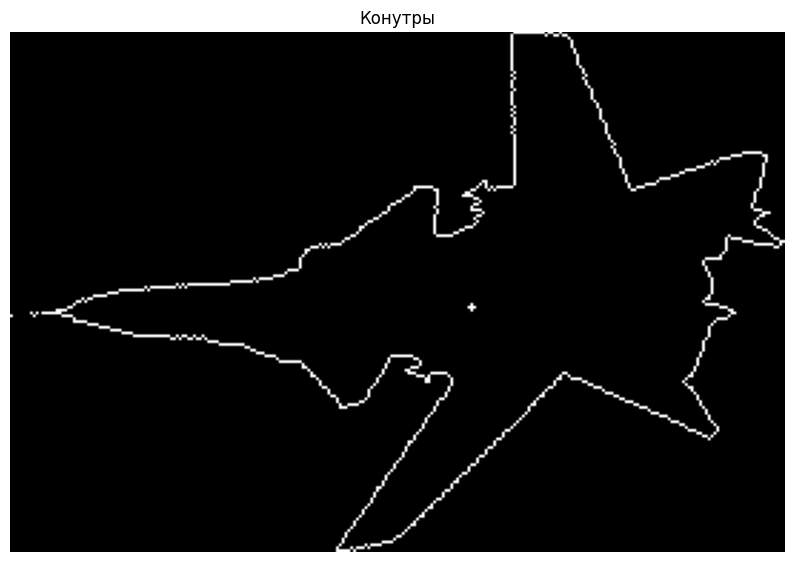

In [512]:
binary_image = binarize_image(image)

mask = np.zeros(binary_image.shape[:2], dtype=np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
center_of_gravity = np.mean(np.vstack([contour.squeeze() for contour in contours[::-1]]), axis=0)
print(f'CG = {center_of_gravity}')
cv2.drawContours(mask, contours[::-1], -1, (255), thickness=1)
cv2.circle(mask, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)

x, y, w, h = cv2.boundingRect(mask)

cropped_image = mask[y:y+h, x:x+w]

plt.figure(figsize=(10, 10))
plt.imshow(cropped_image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
plt.show()

In [513]:
# for contour in contours:
#         characteristic_points, cg = find_characteristic_points(contour, num_points, center_of_gravity)
#         all_characteristic_points.extend(characteristic_points)
#         if center_of_gravity is None:
#             center_of_gravity = cg
#             print(f'CG = {center_of_gravity}')

In [514]:
# def find_characteristic_points(contour, num_points, center_of_gravity):
#     # Проверка на количество точек в контуре
#     num_points = min(len(contour), num_points)

#     print(f'n = {num_points}', f'countours len = {len(contour)}')  # Ограничиваем количество точек количеством точек в контуре
#     if contour.ndim == 3:  # Shape (n, 1, 2)
#         contour = contour.reshape(-1, 2)  # Reshape to (n, 2)

#     # Вычисляем расстояния от центра масс до всех точек контура
#     distances = np.linalg.norm(contour - center_of_gravity, axis=1)

#     # Сортируем точки по расстоянию от центра масс и выбираем нужное количество
#     sorted_indices = np.argsort(distances)[::-1]  # Сортировка по убыванию
#     characteristic_points = contour[sorted_indices[:num_points-1]]

#     return characteristic_points

In [524]:
def find_characteristic_points(contour, center_of_gravity, num_points, EPS):
    # Проверка на количество точек в контуре
    num_points = max(len(contour), num_points)

    if contour.ndim == 3:  # Shape (n, 1, 2)
        contour = contour.reshape(-1, 2)  # Reshape to (n, 2)

    # Первая точка - наиболее удаленная от центра масс
    distances = np.linalg.norm(contour - center_of_gravity, axis=1)
    first_point_idx = np.argmax(distances)
    characteristic_points = [contour[first_point_idx]]

    # Вторая точка - наиболее удаленная от первой
    distances = np.linalg.norm(contour - characteristic_points[0], axis=1)
    second_point_idx = np.argmax(distances)
    characteristic_points.append(contour[second_point_idx])

    # Процесс выбора следующих точек
    while len(characteristic_points) < num_points:
        # Берем последние две найденные точки
        p1 = characteristic_points[-2]
        p2 = characteristic_points[-1]

        # Вычисляем расстояния от всех точек до прямой, проходящей через p1 и p2
        line_vector = p2 - p1
        line_length = np.linalg.norm(line_vector)

        # Вектор, перпендикулярный прямой
        perp_vector = np.array([-line_vector[1], line_vector[0]], dtype=np.float64)  # Убедимся, что тип данных float64
        perp_vector /= np.linalg.norm(perp_vector)  # Нормализуем

        # Находим расстояние от всех точек до прямой
        distances_to_line = np.abs(np.dot(contour - p1, perp_vector))

        # Находим точку, наиболее удаленную от прямой
        max_distance_idx = np.argmax(distances_to_line)
        max_distance = distances_to_line[max_distance_idx]

        print(max_distance / line_length)

        # Если расстояние от точки до прямой меньше, чем порог EPS, прекращаем
        if max_distance / line_length < EPS:
            break

        # Добавляем эту точку в список характеристических точек
        characteristic_points.append(contour[max_distance_idx])

    return characteristic_points


In [525]:
contours, _ = cv2.findContours(cropped_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
center_of_gravity = np.mean(np.vstack([contour.squeeze() for contour in contours[::-1]]), axis=0)

contour = np.vstack([contour.squeeze() for contour in contours[::-1]])

characteristic_points = find_characteristic_points(contour, center_of_gravity, num_points=400, EPS=0.001)
print(len(characteristic_points))

0.3433184734152442
0.739374780470671
1.3429274758568452
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.389718804920914
0.745182462588606
1.2793653655458397
0.3897188

In [517]:
def remove_duplicates(characteristic_points):
    unique_points = []
    seen = set()  # Множество для отслеживания уникальных точек
    for point in characteristic_points:
        # Преобразуем точку в кортеж, чтобы она могла быть добавлена в множество
        point_tuple = tuple(point)  # Преобразуем точку в кортеж для удобства сравнения
        if point_tuple not in seen:
            seen.add(point_tuple)
            unique_points.append(point)
    return unique_points

characteristic_points = remove_duplicates(characteristic_points)
print(len(characteristic_points))

5


In [518]:
def display_image_with_points(image, characteristic_points, center_of_gravity):
    # Create a copy of the image to draw on
    image_copy = image.copy()

    # Convert the image from BGR to RGB for correct display
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    cv2.line(image_copy, tuple(center_of_gravity.astype(int)),
                               tuple(characteristic_points[0].astype(int)),
                                (255, 0, 0), 1)  # Draw red lines

    # Draw lines between characteristic points
    for i in range(1, len(characteristic_points)):
        cv2.line(image_copy, tuple(characteristic_points[i-1].astype(int)), tuple(characteristic_points[i].astype(int)), (255, 0, 0), 1)  # Draw red lines


        # Draw circles at characteristic points
    for i, point in enumerate(characteristic_points):
        cv2.circle(image_copy, tuple(point.astype(int)), 2, (0, 255, 0), -1)  # Draw green circles

        # Add index text at each point
        cv2.putText(image_copy, str(i+1), tuple(point.astype(int)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy)  # Convert BGR to RGB for Matplotlib
    plt.axis('off')
    plt.title('Характерные точки')
    plt.show()

5


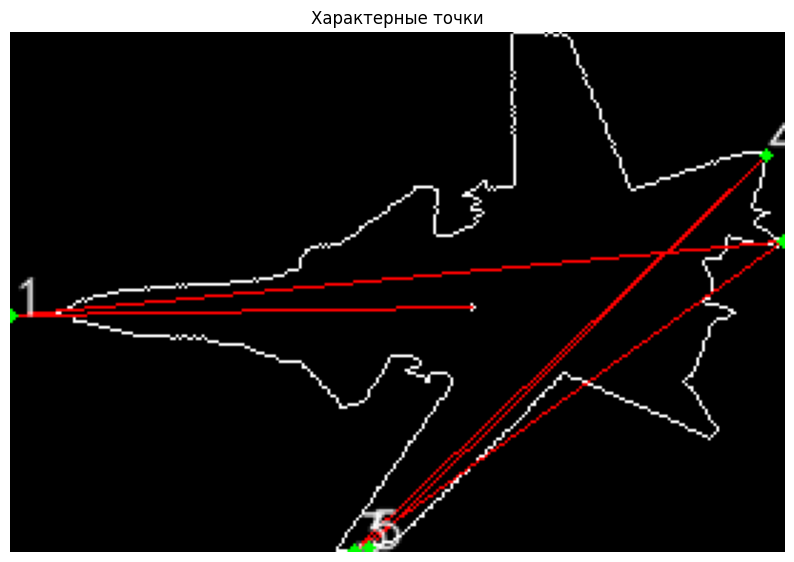

In [519]:
print(len(characteristic_points))
display_image_with_points(cropped_image, characteristic_points, center_of_gravity)

In [520]:
# def main():
#     num_points = 5  # Задайте количество точек

#     # Загружаем и обрабатываем изображение
#     image, binary_image = preprocess_image(PATH)

#     # Находим контуры на бинаризованном изображении (черные объекты)
#     contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Для каждого контура находим характеристические точки
#     all_characteristic_points = []
#     center_of_gravity = None

#     for contour in contours:
#         characteristic_points, cg = find_characteristic_points(contour, num_points=num_points)
#         all_characteristic_points.extend(characteristic_points)
#         if center_of_gravity is None:
#             center_of_gravity = cg  # Сохраняем первый центр масс для отображения

#     # Отображаем исходное изображение с характеристическими точками
#     display_image_with_points(image, all_characteristic_points, center_of_gravity)


In [521]:
# if __name__ == "__main__":
#     main()